# 모두의 딥러닝 개정 3판 
## 19장 세상에 없는 얼굴 GAN, 오토인코더
- **생성적 적대 신경망(Generative Adversarial Networks, GAN(간))**
  * 딥러닝의 원리를 활용해 가상 이미지를 생성하는 알고리즘
  * 한쪽은 가짜를 만들고, 한쪽은 진짜와 비교하는 경합 과정을 이용하여 더욱 정교한 가짜를 만들어냄   
    이것이 바로 GAN의 원리
  * 생성자(Generator): 가상의 이미지 생성   
    랜덤한 픽셀 값으로 채워진 가짜 이미지로 시작해서 판별자의 판별 결과에 따라 지속적으로 업데이트     하며 점차 원하는 이미지 생성
  * 판별자(Discriminator): 생성자에서 넘어온 이미지의 진위 여부를 판별
  
### DCGAN(Deep Convolutional GAN)
  - 컨볼루션 신경망(CNN)을 GAN에 적용한 알고리즘인 DCGAN 실습
  - 판별과 학습이 생성자에서 일어나지 않기에 optimizer, compile 미사용

In [1]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

<< generator 모델 만들 시 참고 >>

- 7*7 크기의 이미지 채널 128개짜리 만들기 위해 가시적으로 식으로 표현 
- **activation=layers.LeakyReLU(0.2)** : 0.2를 부여하기 위해   
  (activation='layers.LeakyReLU(0.2)' : default=0.3으로 실행됨)   
  x < 0,  ReLU(x)=0 으로 불안정하고, 뉴런들이 일찍 소실되는 단점 보완
- **padding='same'** : 입력 크기 = 출력 크기, 다를 경우 크기를 확장하여 0을 채워줌
  아래 생성자 모델의 경우 kernel_size=5이니 상하좌우 2줄씩 0으로 채워짐
- **BatchNormalization** : 입력 데이터의 평균=0, 분산=1 되도록 스케일링 해줌   
    다음 층으로 입력될 값을 일정하게 재배치하는 역할
- **UpSampling2D**: MaxPooling 정반대, 7*7 → 14 *14로 확장
- 판별자로 넘겨주기 직전 **tanh()**  =>  -1 < 출력(판별자 입력) < 1

In [2]:
# 생성자 모델 만들기

generator = models.Sequential()

generator.add(layers.Dense(7*7*128, input_dim=100,  # input_dim=100; 의미X
              activation=layers.LeakyReLU(0.2)))
generator.add(layers.BatchNormalization())

# Reshape: Conv2D() 함수의 input_shape 부분에 들어갈 형태로 정해줌
generator.add(layers.Reshape((7, 7, 128)))
generator.add(layers.UpSampling2D())

generator.add(layers.Conv2D(64, kernel_size=5, padding='same'))
generator.add(layers.BatchNormalization())
generator.add(layers.Activation(layers.LeakyReLU(0.2)))
generator.add(layers.UpSampling2D())
generator.add(layers.Conv2D(1, kernel_size=5, padding='same', activation='tanh'))
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6272)              633472    
                                                                 
 batch_normalization (BatchN  (None, 6272)             25088     
 ormalization)                                                   
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 up_sampling2d (UpSampling2D  (None, 14, 14, 128)      0         
 )                                                               
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 64)        204864    
                                                                 
 batch_normalization_1 (Batc  (None, 14, 14, 64)       2

<<discriminator 모델 만들 시 참고>>
- T(1)/F(0) 판별 -> 이진분류   
- **discriminator.trainable = False** :    
  생성자가 noise를 던지면 순전파를 통해 판별자에게 넘어옴
  판별자는 본인이 얻은 가중치, 오차를 본인이 학습하는데 사용X   
  생성자에게 넘겨주어 생성자 파라미터 갱신   
  판별자는 오류가 많은 noise로 학습하면 안되니 가중치를 저장하는 학습 기능 꺼주기   
  따로 학습시켜야함
- **strides=2** :   
  기본은 1픽셀씩이지만 2픽셀씩 확인하겠다   
  (듬성듬성 특징을 뽑아내겠다, 계산량 줄어듬, 세밀함 줄어듬)
- 생성자의 출력수 = 판별자의 입력수 이므로 맞춰야 했지만 판별자는 T/F 판별만 하면 됨

In [3]:
# 판별자 모델 만들기

discriminator = models.Sequential()

discriminator.add(layers.Conv2D(64, kernel_size=5, input_shape=(28,28,1), strides=2, padding='same'))
discriminator.add(layers.Activation(layers.LeakyReLU(0.2)))
discriminator.add(layers.Dropout(0.3))
discriminator.add(layers.Conv2D(128, kernel_size=5, strides=2, padding='same'))
discriminator.add(layers.Activation(layers.LeakyReLU(0.2)))
discriminator.add(layers.Dropout(0.3))
discriminator.add(layers.Flatten())
discriminator.add(layers.Dense(1, activation='sigmoid'))
discriminator.compile(loss='binary_crossentropy', optimizer='adam')
discriminator.trainable = False

discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 14, 14, 64)        1664      
                                                                 
 activation_1 (Activation)   (None, 14, 14, 64)        0         
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 activation_2 (Activation)   (None, 7, 7, 128)         0         
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 flatten (Flatten)           (None, 6272)             

In [4]:
# 생성사와 판별자를 연결하는 gan 모델 생성하기
ginput = layers.Input(shape=(100,))  # 임의의 100개 벡터를 Input() 통해 생성자에 입력할 ginput 생성
dis_output = discriminator(generator(ginput))  # 판별자가 입력 값을 판별한 값
gan = models.Model(ginput, dis_output)
gan.compile(loss='binary_crossentropy', optimizer='adam')
gan.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 sequential (Sequential)     (None, 28, 28, 1)         865281    
                                                                 
 sequential_1 (Sequential)   (None, 1)                 212865    
                                                                 
Total params: 1,078,146
Trainable params: 852,609
Non-trainable params: 225,537
_________________________________________________________________


In [5]:
if not os.path.exists('data/gan_images'):
    os.mkdir('data/gan_images')
    
def gan_train(epoch, batch_size, saving_interval):
    (X_train, _), (_, _) = mnist.load_data()  # X_train만 필요해서 나머지 버리기
    X_train = X_train.reshape(X_train.shape[0], 28 ,28, 1).astype(float)
    X_train = (X_train - 127.5) / 127.5 
    # -1~1  값으로 바꿈
    # generator 출력층 activation='tanh' 이므로
    # X_train : 생성자가 갖고 온 값 오차 계산, X_train 학습시키기
    
    true = np.ones((batch_size, 1))  # row; batch_size, column ;1개, 값: 1
    fake = np.zeros((batch_size, 1))
    
    for i in range(epoch):
        # randint: 0 ~ X_train.shape[0] 에서 batch_size개만큼 랜덤하게 정수를 뽑아라
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        # batch_size개 만큼
        imgs = X_train[idx]
        d_loss_real = discriminator.train_on_batch(imgs, true)  # 답을 주고 학습하라고 시킴
        
        # 가짜 노이즈 생성
        noise = np.random.normal(0, 1, (batch_size, 100))
        gen_imgs = generator.predict(noise)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
        
        # 판별자의 오차
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
        g_loss = gan.train_on_batch(noise, true)
        
        print('epoch:%d' % i, ' d_loss:%.4f' % d_loss, ' g_loss:%.4f' % g_loss)
        
        # 중간 과정을 이미지로 저장
        if i % saving_interval == 0:
              #r, c = 5, 5
              noise = np.random.normal(0, 1, (25, 100))
              gen_imgs = generator.predict(noise)

              # Rescale images 0 - 1
              gen_imgs = 0.5 * gen_imgs + 0.5

              fig, axs = plt.subplots(5, 5)
              count = 0
              for j in range(5):
                  for k in range(5):
                      axs[j, k].imshow(gen_imgs[count, :, :, 0], cmap='gray')
                      axs[j, k].axis('off')
                      count += 1
              fig.savefig("data/gan_images/gan_mnist_%d.png" % i)

1/1 [==============================] - 0s 155ms/step
epoch:0  d_loss:0.7304  g_loss:0.5473
1/1 [==============================] - 0s 31ms/step
epoch:1  d_loss:0.5361  g_loss:0.2985
1/1 [==============================] - 0s 31ms/step
epoch:2  d_loss:0.5044  g_loss:0.1899
1/1 [==============================] - 0s 18ms/step
epoch:3  d_loss:0.5090  g_loss:0.1824
1/1 [==============================] - 0s 29ms/step
epoch:4  d_loss:0.4956  g_loss:0.3032
1/1 [==============================] - 0s 29ms/step
epoch:5  d_loss:0.4729  g_loss:0.5258
1/1 [==============================] - 0s 15ms/step
epoch:6  d_loss:0.4922  g_loss:0.7512
1/1 [==============================] - 0s 20ms/step
epoch:7  d_loss:0.5077  g_loss:0.7973
1/1 [==============================] - 0s 36ms/step
epoch:8  d_loss:0.6086  g_loss:0.6479
1/1 [==============================] - 0s 31ms/step
epoch:9  d_loss:0.6425  g_loss:0.5209
1/1 [==============================] - 0s 30ms/step
epoch:10  d_loss:0.6386  g_loss:0.5161
1/1 [===

epoch:89  d_loss:0.4214  g_loss:2.0265
1/1 [==============================] - 0s 27ms/step
epoch:90  d_loss:0.4493  g_loss:1.6137
1/1 [==============================] - 0s 30ms/step
epoch:91  d_loss:0.4140  g_loss:1.5351
1/1 [==============================] - 0s 30ms/step
epoch:92  d_loss:0.3895  g_loss:1.2950
1/1 [==============================] - 0s 31ms/step
epoch:93  d_loss:0.3729  g_loss:1.6214
1/1 [==============================] - 0s 30ms/step
epoch:94  d_loss:0.3385  g_loss:1.6143
1/1 [==============================] - 0s 28ms/step
epoch:95  d_loss:0.3136  g_loss:1.8109
1/1 [==============================] - 0s 29ms/step
epoch:96  d_loss:0.5223  g_loss:1.6484
1/1 [==============================] - 0s 30ms/step
epoch:97  d_loss:0.3680  g_loss:1.2874
1/1 [==============================] - 0s 30ms/step
epoch:98  d_loss:0.3742  g_loss:1.2871
1/1 [==============================] - 0s 42ms/step
epoch:99  d_loss:0.3548  g_loss:1.4068
1/1 [==============================] - 0s 31ms/step

1/1 [==============================] - 0s 30ms/step
epoch:179  d_loss:0.4378  g_loss:2.0631
1/1 [==============================] - 0s 24ms/step
epoch:180  d_loss:0.4416  g_loss:2.3900
1/1 [==============================] - 0s 26ms/step
epoch:181  d_loss:0.4025  g_loss:2.0328
1/1 [==============================] - 0s 30ms/step
epoch:182  d_loss:0.5204  g_loss:2.2136
1/1 [==============================] - 0s 17ms/step
epoch:183  d_loss:0.4311  g_loss:2.0396
1/1 [==============================] - 0s 18ms/step
epoch:184  d_loss:0.4468  g_loss:2.2246
1/1 [==============================] - 0s 31ms/step
epoch:185  d_loss:0.4736  g_loss:1.7929
1/1 [==============================] - 0s 20ms/step
epoch:186  d_loss:0.5526  g_loss:1.8561
1/1 [==============================] - 0s 22ms/step
epoch:187  d_loss:0.4547  g_loss:2.2978
1/1 [==============================] - 0s 31ms/step
epoch:188  d_loss:0.4395  g_loss:2.5560
1/1 [==============================] - 0s 21ms/step
epoch:189  d_loss:0.3882  g_

1/1 [==============================] - 0s 26ms/step
epoch:356  d_loss:0.5492  g_loss:2.2791
1/1 [==============================] - 0s 30ms/step
epoch:357  d_loss:0.6134  g_loss:1.6335
1/1 [==============================] - 0s 34ms/step
epoch:358  d_loss:0.5533  g_loss:1.5380
1/1 [==============================] - 0s 31ms/step
epoch:359  d_loss:0.5040  g_loss:1.4514
1/1 [==============================] - 0s 32ms/step
epoch:360  d_loss:0.5106  g_loss:2.3249
1/1 [==============================] - 0s 40ms/step
epoch:361  d_loss:0.5420  g_loss:2.4420
1/1 [==============================] - 0s 31ms/step
epoch:362  d_loss:0.4756  g_loss:2.2056
1/1 [==============================] - 0s 32ms/step
epoch:363  d_loss:0.5952  g_loss:1.9187
1/1 [==============================] - 0s 31ms/step
epoch:364  d_loss:0.3794  g_loss:2.3615
1/1 [==============================] - 0s 30ms/step
epoch:365  d_loss:0.3447  g_loss:2.4691
1/1 [==============================] - 0s 30ms/step
epoch:366  d_loss:0.4941  g_

1/1 [==============================] - 0s 40ms/step
epoch:533  d_loss:0.1131  g_loss:3.6427
1/1 [==============================] - 0s 32ms/step
epoch:534  d_loss:0.1267  g_loss:4.4566
1/1 [==============================] - 0s 39ms/step
epoch:535  d_loss:0.2718  g_loss:2.8551
1/1 [==============================] - 0s 33ms/step
epoch:536  d_loss:0.1512  g_loss:3.4278
1/1 [==============================] - 0s 30ms/step
epoch:537  d_loss:0.1084  g_loss:3.4234
1/1 [==============================] - 0s 31ms/step
epoch:538  d_loss:0.2109  g_loss:3.4485
1/1 [==============================] - 0s 31ms/step
epoch:539  d_loss:0.1966  g_loss:3.2274
1/1 [==============================] - 0s 34ms/step
epoch:540  d_loss:0.1852  g_loss:2.5378
1/1 [==============================] - 0s 23ms/step
epoch:541  d_loss:0.1604  g_loss:3.1648
1/1 [==============================] - 0s 17ms/step
epoch:542  d_loss:0.1895  g_loss:3.2385
1/1 [==============================] - 0s 23ms/step
epoch:543  d_loss:0.1439  g_

1/1 [==============================] - 0s 18ms/step
epoch:710  d_loss:0.3070  g_loss:2.0530
1/1 [==============================] - 0s 32ms/step
epoch:711  d_loss:0.4272  g_loss:1.9980
1/1 [==============================] - 0s 33ms/step
epoch:712  d_loss:0.4313  g_loss:2.2407
1/1 [==============================] - 0s 32ms/step
epoch:713  d_loss:0.4194  g_loss:2.2975
1/1 [==============================] - 0s 23ms/step
epoch:714  d_loss:0.4078  g_loss:2.9410
1/1 [==============================] - 0s 31ms/step
epoch:715  d_loss:0.5133  g_loss:2.0650
1/1 [==============================] - 0s 18ms/step
epoch:716  d_loss:0.4232  g_loss:2.4537
1/1 [==============================] - 0s 21ms/step
epoch:717  d_loss:0.4585  g_loss:2.0265
1/1 [==============================] - 0s 30ms/step
epoch:718  d_loss:0.2947  g_loss:2.4842
1/1 [==============================] - 0s 31ms/step
epoch:719  d_loss:0.4618  g_loss:2.1263
1/1 [==============================] - 0s 16ms/step
epoch:720  d_loss:0.4160  g_

1/1 [==============================] - 0s 32ms/step
epoch:887  d_loss:0.6275  g_loss:1.3590
1/1 [==============================] - 0s 33ms/step
epoch:888  d_loss:0.5182  g_loss:1.5328
1/1 [==============================] - 0s 32ms/step
epoch:889  d_loss:0.6035  g_loss:1.4335
1/1 [==============================] - 0s 30ms/step
epoch:890  d_loss:0.6348  g_loss:1.0882
1/1 [==============================] - 0s 31ms/step
epoch:891  d_loss:0.6918  g_loss:1.1676
1/1 [==============================] - 0s 17ms/step
epoch:892  d_loss:0.5607  g_loss:1.2111
1/1 [==============================] - 0s 32ms/step
epoch:893  d_loss:0.5554  g_loss:1.1886
1/1 [==============================] - 0s 26ms/step
epoch:894  d_loss:0.4315  g_loss:1.3730
1/1 [==============================] - 0s 32ms/step
epoch:895  d_loss:0.4567  g_loss:1.6505
1/1 [==============================] - 0s 31ms/step
epoch:896  d_loss:0.4654  g_loss:1.6441
1/1 [==============================] - 0s 31ms/step
epoch:897  d_loss:0.4314  g_

1/1 [==============================] - 0s 31ms/step
epoch:1064  d_loss:0.2520  g_loss:2.8032
1/1 [==============================] - 0s 33ms/step
epoch:1065  d_loss:0.3074  g_loss:2.7881
1/1 [==============================] - 0s 25ms/step
epoch:1066  d_loss:0.1922  g_loss:3.5230
1/1 [==============================] - 0s 31ms/step
epoch:1067  d_loss:0.2766  g_loss:3.3366
1/1 [==============================] - 0s 35ms/step
epoch:1068  d_loss:0.4128  g_loss:1.9712
1/1 [==============================] - 0s 31ms/step
epoch:1069  d_loss:0.4990  g_loss:1.5494
1/1 [==============================] - 0s 27ms/step
epoch:1070  d_loss:0.3672  g_loss:2.1770
1/1 [==============================] - 0s 30ms/step
epoch:1071  d_loss:0.4251  g_loss:2.0423
1/1 [==============================] - 0s 30ms/step
epoch:1072  d_loss:0.3659  g_loss:2.4195
1/1 [==============================] - 0s 26ms/step
epoch:1073  d_loss:0.3648  g_loss:2.1963
1/1 [==============================] - 0s 32ms/step
epoch:1074  d_loss

epoch:1239  d_loss:0.4298  g_loss:2.1589
1/1 [==============================] - 0s 32ms/step
epoch:1240  d_loss:0.4225  g_loss:2.4538
1/1 [==============================] - 0s 31ms/step
epoch:1241  d_loss:0.3641  g_loss:2.5417
1/1 [==============================] - 0s 32ms/step
epoch:1242  d_loss:0.4360  g_loss:2.3564
1/1 [==============================] - 0s 31ms/step
epoch:1243  d_loss:0.4002  g_loss:2.3764
1/1 [==============================] - 0s 31ms/step
epoch:1244  d_loss:0.5082  g_loss:2.2392
1/1 [==============================] - 0s 33ms/step
epoch:1245  d_loss:0.6025  g_loss:2.0724
1/1 [==============================] - 0s 30ms/step
epoch:1246  d_loss:0.3731  g_loss:1.6134
1/1 [==============================] - 0s 32ms/step
epoch:1247  d_loss:0.5406  g_loss:1.9262
1/1 [==============================] - 0s 35ms/step
epoch:1248  d_loss:0.4875  g_loss:2.0218
1/1 [==============================] - 0s 31ms/step
epoch:1249  d_loss:0.4507  g_loss:2.1282
1/1 [========================

1/1 [==============================] - 0s 33ms/step
epoch:1328  d_loss:0.3808  g_loss:1.7907
1/1 [==============================] - 0s 32ms/step
epoch:1329  d_loss:0.3727  g_loss:1.8531
1/1 [==============================] - 0s 31ms/step
epoch:1330  d_loss:0.3142  g_loss:1.7600
1/1 [==============================] - 0s 32ms/step
epoch:1331  d_loss:0.4090  g_loss:1.4663
1/1 [==============================] - 0s 32ms/step
epoch:1332  d_loss:0.3545  g_loss:2.2077
1/1 [==============================] - 0s 24ms/step
epoch:1333  d_loss:0.3452  g_loss:2.3247
1/1 [==============================] - 0s 30ms/step
epoch:1334  d_loss:0.3598  g_loss:2.5887
1/1 [==============================] - 0s 30ms/step
epoch:1335  d_loss:0.3993  g_loss:2.0029
1/1 [==============================] - 0s 38ms/step
epoch:1336  d_loss:0.4919  g_loss:1.4272
1/1 [==============================] - 0s 31ms/step
epoch:1337  d_loss:0.3084  g_loss:1.8322
1/1 [==============================] - 0s 20ms/step
epoch:1338  d_loss

epoch:1415  d_loss:0.4551  g_loss:1.4608
1/1 [==============================] - 0s 17ms/step
epoch:1416  d_loss:0.4483  g_loss:1.7192
1/1 [==============================] - 0s 18ms/step
epoch:1417  d_loss:0.5807  g_loss:1.5091
1/1 [==============================] - 0s 29ms/step
epoch:1418  d_loss:0.4197  g_loss:1.6313
1/1 [==============================] - 0s 47ms/step
epoch:1419  d_loss:0.5878  g_loss:1.3984
1/1 [==============================] - 0s 31ms/step
epoch:1420  d_loss:0.5100  g_loss:1.0716
1/1 [==============================] - 0s 31ms/step
epoch:1421  d_loss:0.6343  g_loss:1.3321
1/1 [==============================] - 0s 31ms/step
epoch:1422  d_loss:0.4149  g_loss:1.6241
1/1 [==============================] - 0s 31ms/step
epoch:1423  d_loss:0.5500  g_loss:1.6894
1/1 [==============================] - 0s 36ms/step
epoch:1424  d_loss:0.4042  g_loss:1.8004
1/1 [==============================] - 0s 23ms/step
epoch:1425  d_loss:0.5327  g_loss:1.4563
1/1 [========================

1/1 [==============================] - 0s 38ms/step
epoch:1504  d_loss:0.3520  g_loss:1.6347
1/1 [==============================] - 0s 16ms/step
epoch:1505  d_loss:0.3746  g_loss:1.7971
1/1 [==============================] - 0s 26ms/step
epoch:1506  d_loss:0.2811  g_loss:1.9710
1/1 [==============================] - 0s 40ms/step
epoch:1507  d_loss:0.2980  g_loss:2.3073
1/1 [==============================] - 0s 31ms/step
epoch:1508  d_loss:0.4280  g_loss:2.0369
1/1 [==============================] - 0s 30ms/step
epoch:1509  d_loss:0.4189  g_loss:1.6241
1/1 [==============================] - 0s 23ms/step
epoch:1510  d_loss:0.4424  g_loss:1.9144
1/1 [==============================] - 0s 17ms/step
epoch:1511  d_loss:0.4714  g_loss:1.9327
1/1 [==============================] - 0s 19ms/step
epoch:1512  d_loss:0.5245  g_loss:1.7689
1/1 [==============================] - 0s 31ms/step
epoch:1513  d_loss:0.5021  g_loss:1.6410
1/1 [==============================] - 0s 31ms/step
epoch:1514  d_loss

epoch:1679  d_loss:0.3824  g_loss:1.5520
1/1 [==============================] - 0s 28ms/step
epoch:1680  d_loss:0.3771  g_loss:1.7873
1/1 [==============================] - 0s 32ms/step
epoch:1681  d_loss:0.4516  g_loss:1.9511
1/1 [==============================] - 0s 32ms/step
epoch:1682  d_loss:0.4953  g_loss:2.0734
1/1 [==============================] - 0s 32ms/step
epoch:1683  d_loss:0.4627  g_loss:2.0701
1/1 [==============================] - 0s 36ms/step
epoch:1684  d_loss:0.4545  g_loss:1.4768
1/1 [==============================] - 0s 34ms/step
epoch:1685  d_loss:0.3422  g_loss:1.7680
1/1 [==============================] - 0s 31ms/step
epoch:1686  d_loss:0.4472  g_loss:1.4801
1/1 [==============================] - 0s 37ms/step
epoch:1687  d_loss:0.4758  g_loss:1.5093
1/1 [==============================] - 0s 31ms/step
epoch:1688  d_loss:0.4659  g_loss:1.4770
1/1 [==============================] - 0s 31ms/step
epoch:1689  d_loss:0.4368  g_loss:2.0193
1/1 [========================

1/1 [==============================] - 0s 34ms/step
epoch:1768  d_loss:0.7136  g_loss:1.2184
1/1 [==============================] - 0s 18ms/step
epoch:1769  d_loss:0.5805  g_loss:0.9922
1/1 [==============================] - 0s 32ms/step
epoch:1770  d_loss:0.6353  g_loss:1.3665
1/1 [==============================] - 0s 30ms/step
epoch:1771  d_loss:0.6282  g_loss:1.3781
1/1 [==============================] - 0s 31ms/step
epoch:1772  d_loss:0.6634  g_loss:1.1741
1/1 [==============================] - 0s 30ms/step
epoch:1773  d_loss:0.7266  g_loss:1.0995
1/1 [==============================] - 0s 30ms/step
epoch:1774  d_loss:0.5706  g_loss:1.2926
1/1 [==============================] - 0s 31ms/step
epoch:1775  d_loss:0.4773  g_loss:1.3423
1/1 [==============================] - 0s 30ms/step
epoch:1776  d_loss:0.4199  g_loss:1.9752
1/1 [==============================] - 0s 31ms/step
epoch:1777  d_loss:0.4958  g_loss:1.5633
1/1 [==============================] - 0s 31ms/step
epoch:1778  d_loss

epoch:1855  d_loss:0.4176  g_loss:1.6345
1/1 [==============================] - 0s 32ms/step
epoch:1856  d_loss:0.4264  g_loss:1.5232
1/1 [==============================] - 0s 32ms/step
epoch:1857  d_loss:0.4539  g_loss:1.8287
1/1 [==============================] - 0s 32ms/step
epoch:1858  d_loss:0.4323  g_loss:1.6801
1/1 [==============================] - 0s 32ms/step
epoch:1859  d_loss:0.4895  g_loss:1.5477
1/1 [==============================] - 0s 42ms/step
epoch:1860  d_loss:0.5174  g_loss:1.5432
1/1 [==============================] - 0s 32ms/step
epoch:1861  d_loss:0.4293  g_loss:1.5248
1/1 [==============================] - 0s 31ms/step
epoch:1862  d_loss:0.5119  g_loss:1.2428
1/1 [==============================] - 0s 34ms/step
epoch:1863  d_loss:0.5434  g_loss:1.1799
1/1 [==============================] - 0s 27ms/step
epoch:1864  d_loss:0.3803  g_loss:1.9924
1/1 [==============================] - 0s 35ms/step
epoch:1865  d_loss:0.4025  g_loss:1.9793
1/1 [========================

1/1 [==============================] - 0s 31ms/step
epoch:1944  d_loss:0.4309  g_loss:1.6543
1/1 [==============================] - 0s 37ms/step
epoch:1945  d_loss:0.6867  g_loss:1.5063
1/1 [==============================] - 0s 52ms/step
epoch:1946  d_loss:0.6331  g_loss:1.7211
1/1 [==============================] - 0s 82ms/step
epoch:1947  d_loss:0.6952  g_loss:1.5668
1/1 [==============================] - 0s 34ms/step
epoch:1948  d_loss:0.4199  g_loss:1.5956
1/1 [==============================] - 0s 34ms/step
epoch:1949  d_loss:0.5330  g_loss:1.5312
1/1 [==============================] - 0s 31ms/step
epoch:1950  d_loss:0.5998  g_loss:1.7510
1/1 [==============================] - 0s 16ms/step
epoch:1951  d_loss:0.4475  g_loss:1.4376
1/1 [==============================] - 0s 32ms/step
epoch:1952  d_loss:0.4474  g_loss:1.3130
1/1 [==============================] - 0s 33ms/step
epoch:1953  d_loss:0.4652  g_loss:1.7344
1/1 [==============================] - 0s 23ms/step
epoch:1954  d_loss

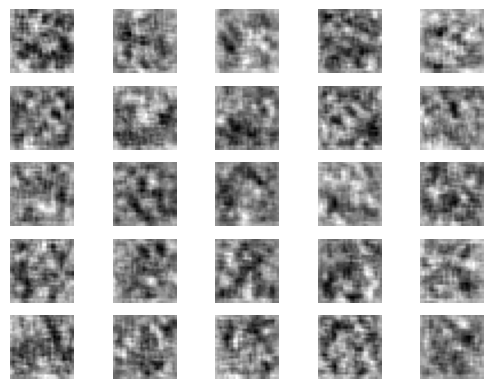

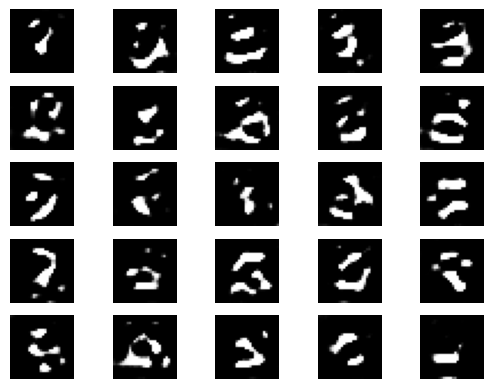

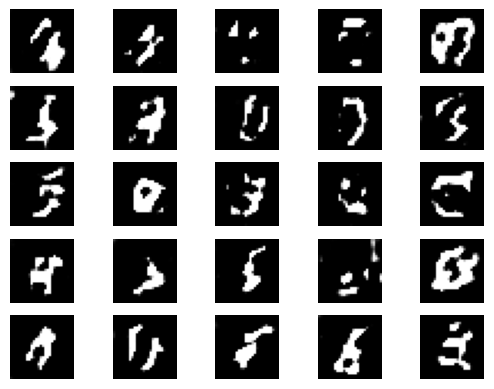

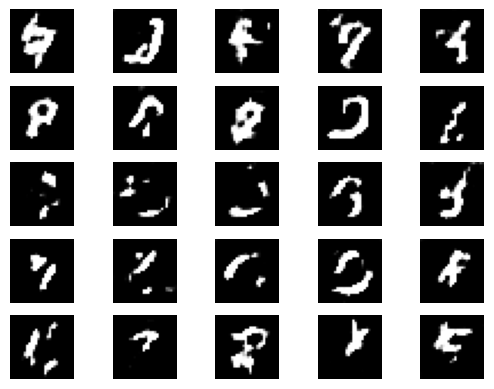

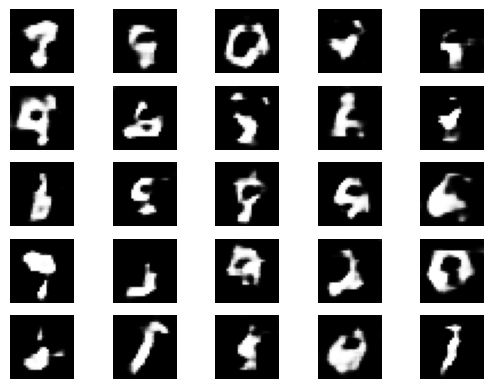

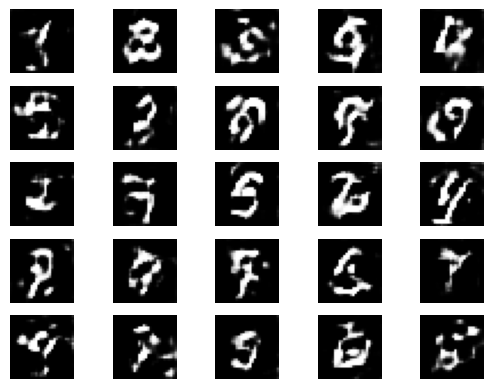

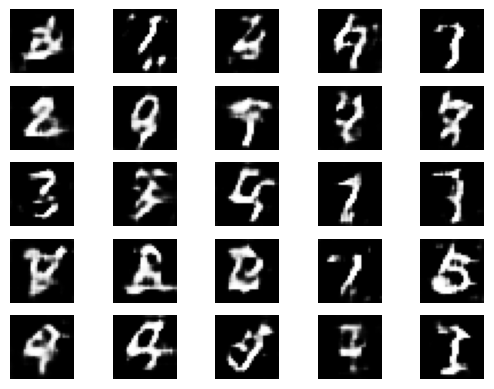

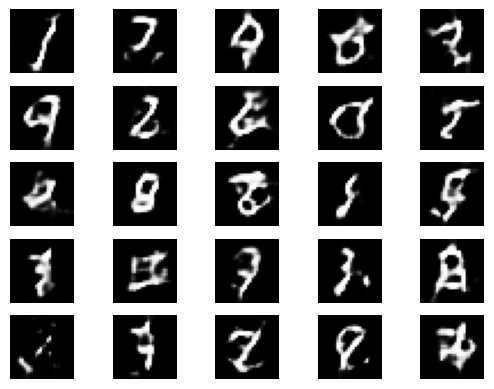

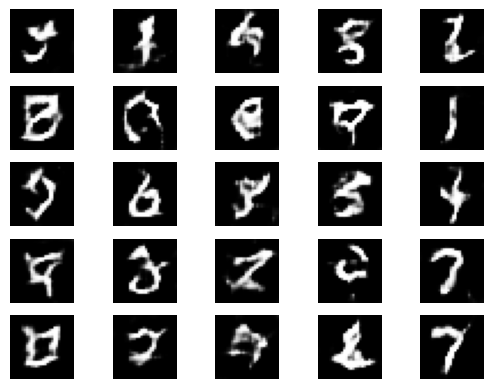

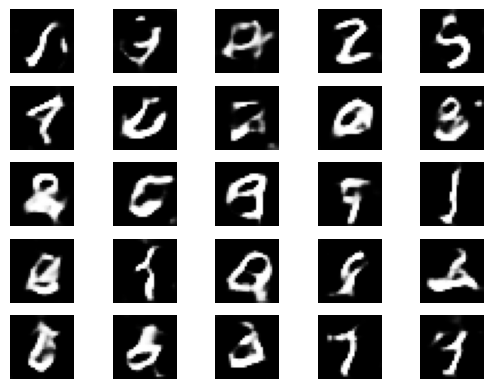

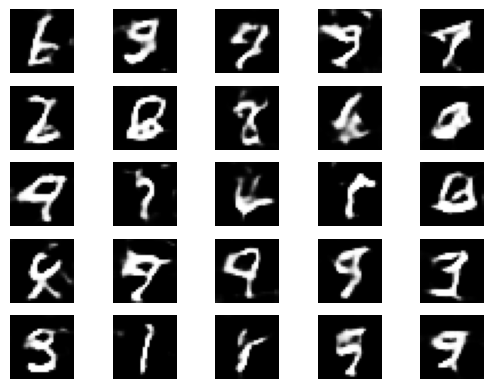

In [6]:
gan_train(2001, 32, 200)  # epoch + 1, batch_size, saving_interval

- 학습이 진행될수록 생성자가 만든 G(input)이 실제와 너무나 가까워져 이것으로 만든 D(G(input))과 실제 데이터로 만든 D(x)를 잘 구별하지 못하게 됨. 정확도가 0.5에 가까워질 때 생성자 학습 종료됨.